## 6.1 优化算法理论
> 本小节理论公式较多，其中夹着一些代码演示方便读者理解。

### 6.1.1 优化和深度学习
尽管优化提供了一种最大限度地减少深度学习损失函数的方法，但实质上，优化和深度学习的目标是根本不同的：
* 前者主要关注的是**最小化目标**
* 后者则关注在给定有限数据量的情况下寻找**合适的模型**。

优化的目标是减少**训练误差**。但是，深度学习（或更广义地说，统计推断）的目标是**减少泛化误差**。为了实现后者，除了使用优化算法来减少训练误差之外，我们还需要注意过拟合。

下面我们通过实际的例子来展示：

In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

经验风险是训练数据集的**平均损失**，而风险则是整个数据群的预期损失。

下面我们定义了两个函数：风险函数`f`和经验风险函数`g`。假设我们只有有限量的训练数据。因此，这里的`g`不如`f`平滑。

In [13]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

下图说明，训练数据集的最低经验风险可能与最低风险（泛化误差）不同。

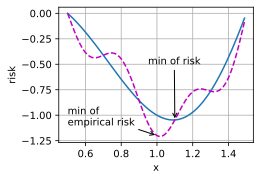

In [14]:
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

**回顾一下之前的鞍点**

鞍点（saddle point）是指函数的所有梯度都消失但既不是全局最小值也不是局部最小值的任何位置。如下图所示：

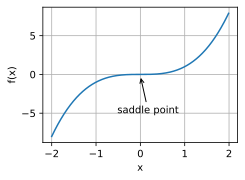

In [15]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

如下例所示，较高维度的鞍点甚至更加隐蔽。考虑这个$f=x^2-y^2$函数。它的鞍点为$(0, 0)$。这是关于$y$的最大值，也是关于$x$的最小值。

/Users/gary/miniconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


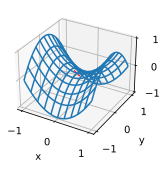

In [16]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

### 6.2 优化算法

#### 6.2.1 动量法
> 由于之前的章节对此有所介绍这里不展开讨论，我们看看它的代码实现

$$
\begin{aligned}
&\mathbf{v}_t \leftarrow \beta \mathbf{v}_{t-1}+\mathbf{g}_{t, t-1} \\
&\mathbf{x}_t \leftarrow \mathbf{x}_{t-1}-\eta_t \mathbf{v}_t
\end{aligned}
$$

相比于小批量随机梯度下降，动量方法需要维护一组辅助变量，即速度。 它与梯度以及优化问题的变量具有相同的形状。 在下面的实现中，我们称这些变量为`states`。


* **从零开始实现**

In [25]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.244, 0.003 sec/epoch


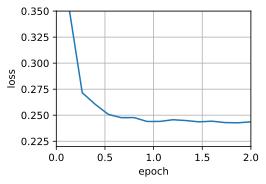

In [26]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数momentum增加到0.9时，它相当于有效样本数量增加到$\frac{1}{1-0.9}=10$。我们将学习率略微降至0.01，以确保可控。

loss: 0.246, 0.003 sec/epoch


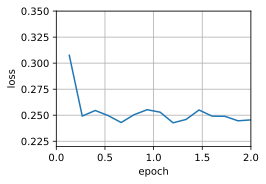

In [27]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的困难，将其设置0.005为会产生良好的收敛性能。

loss: 0.243, 0.003 sec/epoch


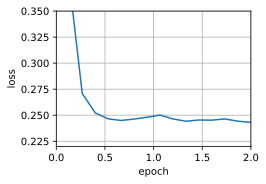

In [28]:
train_momentum(0.005, 0.9)

* 简洁实现

loss: 0.256, 0.003 sec/epoch


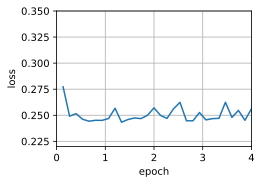

In [29]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

#### 6.2.2 AdaGrad算法
假设我们正在训练一个语言模型。为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。

现在讨论关于稀疏特征（即只在偶尔出现的特征）的模型训练，这对自然语言来说很常见。
例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

**只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。**
鉴于学习率下降，我们可能最终会面临这样的情况：
* 常见特征的参数相当迅速地收敛到最佳值
* 而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值。

换句话说，学习率要么对于**常见特征而言降低太慢**，要么对于**不常见特征而言降低太快**。解决此问题的一个方法是记录我们看到特定特征的次数，然后将其用作调整学习率。

我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是按照坐标顺序应用。也就是说，$\mathbf{v}^2$有条目$v_i^2$。
同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。

与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。

最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许每个坐标有单独的学习率。与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。对于凸问题，这完全足够了。

然而，在深度学习中，我们可能希望更慢地降低学习率。这引出了许多`AdaGrad`算法的变体，我们将在后续中讨论它们。眼下让我们先看看它在二次凸问题中的表现如何。我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。
可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

In [19]:
import math

epoch 20, x1: -2.382563, x2: -0.158591


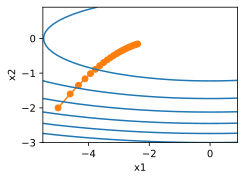

In [20]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

我们将学习率提高到$2$，可以看到更好的表现。这已经表明，即使在**无噪声**的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。

epoch 20, x1: -0.002295, x2: -0.000000


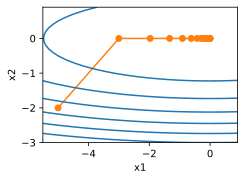

In [21]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

**从零开始实现`AdaGrad`算法**
同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。

In [22]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.242, 0.004 sec/epoch


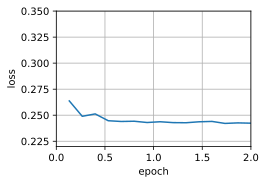

In [23]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

**简洁实现**
直接使用深度学习框架中提供的AdaGrad算法来训练模型。

loss: 0.242, 0.003 sec/epoch


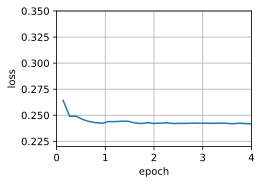

In [24]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

#### 6.2.3 Adam算法
Adam算法将所有这些技术汇总到一个高效的学习算法中。 不出预料，作为深度学习中使用的更**强大和有效**的优化算法之一，它非常受欢迎。


Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

* 从零开始实现

从头开始实现Adam算法并不难。为方便起见，我们将时间步$t$存储在`hyperparams`字典中。除此之外，一切都很简单。

In [30]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

现在，我们用以上Adam算法来训练模型，这里我们使用$\eta = 0.01$的学习率。

loss: 0.243, 0.003 sec/epoch


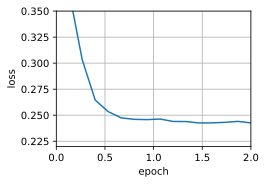

In [31]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

* 简洁实现

loss: 0.245, 0.003 sec/epoch


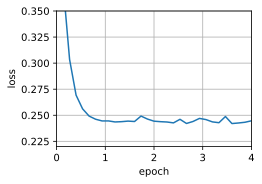

In [32]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### 6.3 预热

在某些情况下，初始化参数不足以得到良好的解。

这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。 对此，一方面，我们可以选择一个足够小的学习率， 从而防止一开始发散，然而这样进展太缓慢。 另一方面，较高的学习率最初就会导致发散。


解决这种困境的一个相当简单的解决方法是**使用预热期**，在此期间学习率将增加至**初始最大值**，然后冷却直到优化过程结束。 为了简单起见，通常使用线性递增。 这引出了如下图片所示的时间表。


![](https://zh.d2l.ai/_images/output_lr-scheduler_1dfeb6_128_0.svg)